# [Seasonality](https://www.kaggle.com/code/ryanholbrook/seasonality)

## What is Seasonality?
`Seasonality` refers to regular and predictable patterns or fluctuations in data that occur at specific intervals, typically over the course of a year, month, week, or day. These patterns repeat over time and are often influenced by calendar effects, weather patterns, holidays, or other recurring events.

## Types of features for seasonality model

* Time-based Features<br>
* <ins>**Seasonal Indicator Variables**</ins><br>
  These are binary or categorical variables that indicate whether a specific time period falls within a particular season or seasonal category. For example:
  * Seasonal quarters: Q1, Q2, Q3, Q4
  * Holiday seasons: Christmas, Thanksgiving, etc.
  * Meteorological seasons: Spring, Summer, Fall, Winter
* Lagged Variables<br>
* Moving Averages<br>
  Moving averages smooth out short-term fluctuations in the data and highlight longer-term trends or patterns. Seasonal moving averages, such as seasonal means or seasonal medians, can capture the average behavior of the data over specific seasonal intervals.
* Dummy Variables<br>
* <ins>**Furier Terms**</ins><br>
  Fourier terms decompose the time series into different frequency components, allowing for flexible modeling of seasonal patterns with different periodicities.
* Seasonal Decomposition Components<br>
  Seasonal decomposition techniques, such as seasonal-trend decomposition using LOESS (STL) or seasonal decomposition of time series by loess (seas), extract seasonal, trend, and residual components from the time series data. These components can be used as features to model seasonality explicitly.

In this course, we will learn `indicator` and `furier terms`.

## Seasonal indicators
A seasonal indicator is that you taken a seasonal period as a categorical feature and apply one-hot encoding.

For example, by one-hot encoding days of the week, we get weekly seasonal indicators.

Linear regression works best if you drop one of the indicators; we chose drop `Monday` in the frame below:

In [2]:
import pandas as pd

df = pd.read_csv(
    "data/weely_seasonal_indicator.csv",
    index_col='Date',
    parse_dates=['Date'],
)

df.head()

,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Date,,,,,,
2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,1.0,0.0,0.0,0.0,0.0,0.0
2016-01-06,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-07,0.0,0.0,1.0,0.0,0.0,0.0
2016-01-08,0.0,0.0,0.0,1.0,0.0,0.0


Adding seasonal indicators to the training data helps models distinguish means within a seasonal period.
The indicators act as On/Off switches in seasonal mean (black line) plot as shown in diagram below:
![plot](image/seasonal_plot.png)

## Fourier features
For long seasons, e.g. day of year, creating `365 - 1` indicators is impractical.

`Fourier features` could try to capture overall shape of the seasonal curve with just a few features. e.g.
![fourier_feature](image/fourier_feature.png)

> Except sine and cosine weaves shown above, by decomposing the time series into sinusoidal components with different frequencies, `Fourier features` can forecast a wide range of periodic curves, from Simple Harmonic Oscillations to non-linear periodic patterns.


## Choosing Fourier features with the Periodogram
How many Fourier pairs should we actually include in our feature set?
The short answer is `Periodogram`. 

A periodogram is a tool used in signal processing and time series analysis to estimate the frequency content of a signal. It provides a visual representation of the frequency spectrum of the signal, showing the relative strength or power of different frequencie.

* **Identify Significant Frequencies**:<br>
  Look for peaks or significant spikes in the periodogram that indicate dominant frequencies or periodic components in the data. These peaks correspond to the frequencies of the underlying periodic patterns in the time series.
* **Choose Fourier Features**:<br>
  Based on the significant frequencies identified in the periodogram, choose Fourier features to capture these periodic patterns in the data. This may involve selecting sinusoidal basis functions with frequencies corresponding to the peaks in the periodogram.

See a sample `Periodogram` below. There are two major spikes:
* Quarterly: It drops off ater Quarterly, 4 times a year. We will choose 4 Fourier paris to model the annual season.
* Weekly: it's better modeled with indicators.

![periodogram](image/perodiogram_example.png)


## Example - Tunnel Traffic

Load tunnel data and define two functions:
* seasonal_plot
* plot_periodogram

In [7]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")
%matplotlib inline

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
# %config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


tunnel = pd.read_csv("data/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Let's take a look at seasonal plots over a week and over a year.

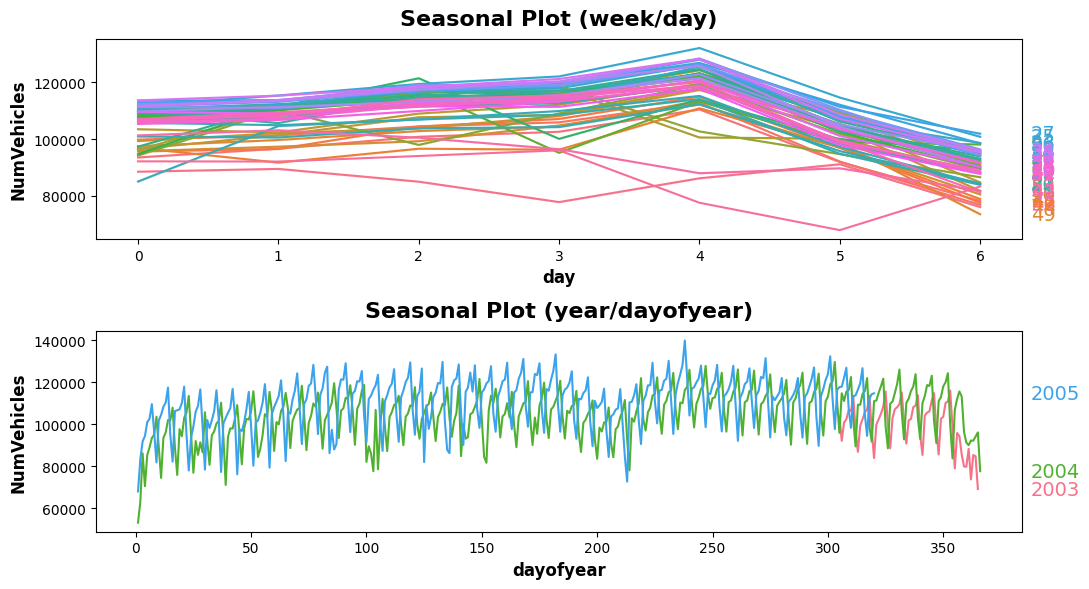

In [8]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year


fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

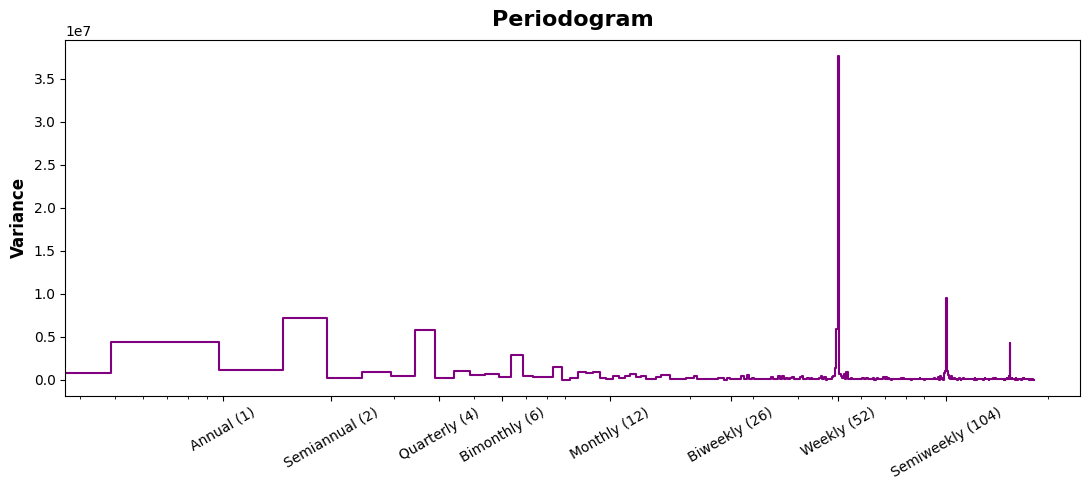

In [9]:
plot_periodogram(tunnel.NumVehicles);

The periodogram agrees with the seasonal plots above:
* a strong weekly season and a weaker annual season.
  * The weekly season we'll model with indicators
  * the annual season with Fourier features
* From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12). so let's use 10 Fourier pairs

### Create seasonal features

We'll create seasonal features with DeterministicProcess. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [12]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index
y = tunnel["NumVehicles"]

### Train linear regression model

In [13]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

### Predict and forecast
Predict with in_sample() data and forecast with out_of_sample() data

In [14]:
y_pred = pd.Series(model.predict(X), index=y.index)

X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

### Plot seasonal forecase

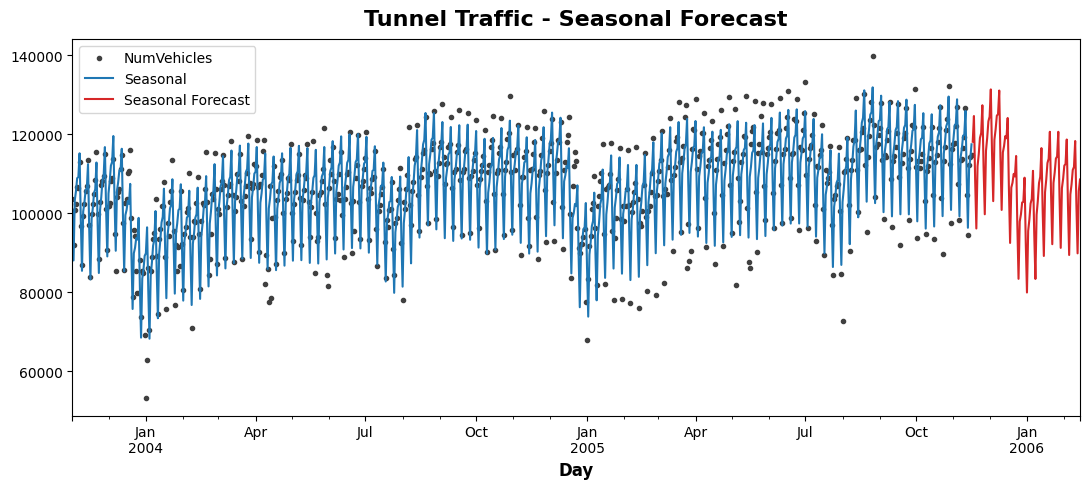

In [15]:
ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()